In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import ode
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Numerical integration
When symbolic integration fails, we turn to numerical methods. This notebook shows a few numerical methods and their pros and cons.

## Trapezoid Rule 

As shown in the [wiki](https://en.wikipedia.org/wiki/Trapezoidal_rule), the workhorse formula here is
$$\int _a ^b f(x)dx \approx (b - a)\left[\frac {f(a) + f(b)}{2}\right] $$Let's dive right into it. We will try and integrate the $sin(x)$ function.

In [4]:
def trapz(function, a, b, number_of_slices=10):
    width = (b - a) / number_of_slices
    start, total, end = a, 0, a + width
    while end <= b:
        total += function(start) + function(end)
        start, end = end, end + width
    approximation = (total / 2) * width
    return approximation

def candidate_function(x):
    return np.sin(x)

We know that $\int _a ^b sin(x) = -cos(b) + cos(a)$. On taking **a** and **b** to be 0 and $\pi$, we get the result of the integration to be $-cos(\pi) + cos(0) = -(-1) + 1 = 2$

In [5]:
a, b = 0, np.pi
trapz(candidate_function, a, b)

1.9835235375094544

We see that the answer is close to the true value. To see just how close it comes with increase in the number of slices, we plot a graph.

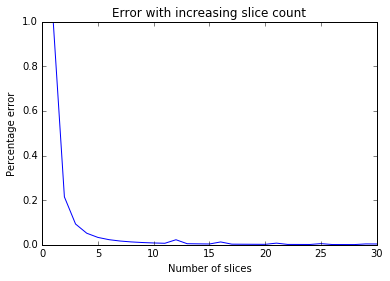

In [6]:
x = list(range(1, 31))
y = [(2. - trapz(candidate_function, a, b, number_of_slices=i)) / 2 for i in x]
plt.plot(x, y)
plt.xlabel('Number of slices')
plt.ylabel('Percentage error')
plt.title('Error with increasing slice count')

This is expected. However, with the decrease in the granularity of the candidate function, how does the number of slices needed to obtain less than 1% error change?  
A good way to visualize why this is happening is this image:
![image showing working of trapz function](https://upload.wikimedia.org/wikipedia/en/a/ab/Trapezium.gif)

In [7]:
def candidate_gen(freq):
    def candidate_function(x):
        return np.sin(x * freq)
    return candidate_function

frequency_counts = np.arange(1, 20, 0.1)
x, y = [], []
for f in frequency_counts:
    cf = candidate_gen(f)
    true_value = ( -np.cos(b) + np.cos(a)) / f
    x.append(f)
    for slices in range(1, 200):
        val = trapz(cf, a, b, number_of_slices=slices)
        percent_error = abs((val - true_value) / true_value)
        if percent_error < 0.1:
            y.append(slices)
            break
    else:  # no value found
        x.pop() # remove the added value
assert len(x) == len(y)
print("{} points evaluated".format(len(x)))

78 points evaluated


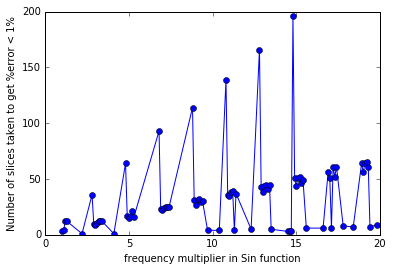

In [8]:
plt.plot(x, y, '-o')
plt.xlabel('frequency multiplier in Sin function')
plt.ylabel('Number of slices taken to get %error < 1%')

- The spikes you can see are periodic due to those points corresponding to zero. This is discussed in another notebook of mine which discusses numerical errors.
- The increase in steps is linear

## Euler's method
As the wiki shows, this method approximates the function using polynomials and is the simplest Runge-Kutta method (we shall see this later on).  

The idea is that while the curve is initially unknown, its starting point, which we denote by $A_0$, is known. Then, from the differential equation, the slope to the curve at $A_0$ can be computed, and so, the tangent line.  

And then we repeat.

In [9]:
def euler(f, x_initial, x_final, y_initial, step):
    h = (x_final - x_initial) / float(step)
    x, y = x_initial, y_initial
    x_points, y_points = [], []
    x_points.append(x); y_points.append(y)
    for i in range(step):
        y += h * f(x, y)
        x += h
        x_points.append(x); y_points.append(y)
    return x_points, y_points

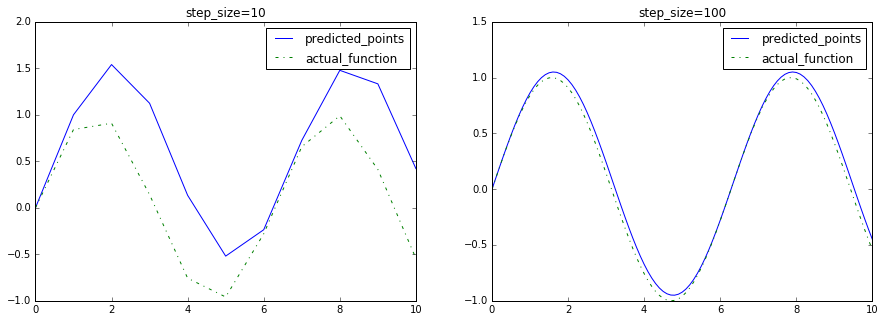

In [10]:
def candidate(x, y):
    return np.cos(x)

step1, step2 = 10, 100
x, y = euler(candidate, 0, 10, 0, 10)
x2, y2 = euler(candidate, 0, 10, 0, 100)

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(x, y, label='predicted_points')
plt.plot(x, np.sin(x), '-.', label='actual_function')
plt.title('step_size={}'.format(step1))
plt.legend()

plt.subplot(122)
plt.plot(x2, y2, label='predicted_points')
plt.plot(x2, np.sin(x2), '-.', label='actual_function')
plt.title('step_size={}'.format(step2))
plt.legend()

We can see that the function is doing very badly. However when we increase the number of steps it performs well. Let us see exactly how well the function performs with change in step size by plotting an error curve with the mean squared error.

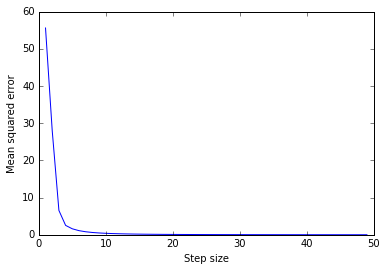

In [11]:
step_size, mse = [], []
for i in range(1, 50):
    step_size.append(i)
    x, y = euler(candidate, 0, 10, 0, i)
    err = sum((_y - np.sin(_x))**2 for _x, _y in zip(x, y)) / len(x)
    mse.append(err)
plt.plot(step_size, mse)
plt.xlabel('Step size')
plt.ylabel('Mean squared error')

This shows that the error falls off very quickly.

## Simpson's method

This is used to numerically integrate differential equations. It is described by the approximation:  
$$\int_a^b f(x)dx \approx \frac{b - a}{6} \left[ f(a) + 4f\left(\frac{a + b}{2}\right) + f(b)\right]$$

Let's get started right away.

In [12]:
def simpson(f, a, b, steps):
    assert steps % 2 == 0, ValueError("Steps must be even (received steps=%d)" % steps)
    h = (b - a) / steps
    s = f(a) + f(b)
    for i in range(1, steps, 2):
        s += 4 * f(a + i * h)
    for i in range(2, steps-1, 2):
        s += 2 * f(a + i * h)
    return s * h / 3